In [264]:
import os
import numpy as np
import cv2
import glob

from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, MaxPooling2D, Cropping2D, Activation, Dropout

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [265]:
def listOfAllFilesInDir(dir):
    filenames = []
    for root, subdirs, files in os.walk(dir):
        if (len(files) > 0):
            filenames.extend([os.path.join(root, filename) for filename in files])
    return filenames

def getSamples():
    # Read in cars and notcars
    car_filenames = listOfAllFilesInDir('vehicles')
    notcar_filenames = listOfAllFilesInDir('non-vehicles')
    samples = [(filename, 1) for filename in car_filenames]
    samples.extend([(filename, 0) for filename in notcar_filenames])
    return samples

In [348]:
def xformImage(image, input_color_space='BGR'):
    output_color_space = 'RGB'
    
    if input_color_space == 'BGR':
        # apply color conversion if other than 'BGR'
        if output_color_space == 'RGB':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif output_color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif output_color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif output_color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif output_color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif output_color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: 
            feature_image = np.copy(image)
    elif input_color_space == 'RGB':
        # apply color conversion if other than 'BGR'
        if output_color_space == 'BGR':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        elif output_color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif output_color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif output_color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif output_color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif output_color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)
    else:
        assert False
    
    return feature_image

def dataGenerator(samples, batch_size=32):
    """
    It is a python generator for samples to feed a batch-size of data
    samples at a time to keras' training phase.
    Args:
        samples: list of tuples to feed the generator
        batch_size: int, size of each batch training works on at a time
    """
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            labels = []
            for sample in batch_samples:
                image = cv2.imread(sample[0])
                image = xformImage(image, input_color_space='BGR')
                label = sample[1]
                images.append(image)
                labels.append(label)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(labels)
            yield shuffle(X_train, y_train)

def numberOfBatches(num_samples, batch_size=32):
    """
    It computes number of batches given total number of samples and batch size.
    Args:
        num_samples: int, total number of samples
        batch_size: int, batch size
    """
    num_batches = num_samples / batch_size
    if (num_samples%batch_size) != 0:
        num_batches += 1
    return num_batches


In [432]:
def vehicleDetectionModel(input_shape=(None, None, 3)):
    """
    
    """
    model = Sequential()
    model.add(Lambda(lambda x: (x / 127.5) - 1.0, input_shape=input_shape))
    model.add(Conv2D(filters=16,  kernel_size=3, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=32,  kernel_size=3, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=64,  kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=1, kernel_size=8, activation='sigmoid'))
    return  model

In [433]:
def train():
    # Keep training and validation samples ready
    samples = getSamples()
    train_samples, validation_samples = train_test_split(samples, test_size=0.2)

    # Setup generators for training and validation samples
    BATCH_SIZE = 64
    train_generator = dataGenerator(train_samples, batch_size=BATCH_SIZE)
    validation_generator = dataGenerator(validation_samples, batch_size=BATCH_SIZE)

    steps_per_epoch = numberOfBatches(len(train_samples), BATCH_SIZE)
    validation_steps = numberOfBatches(len(validation_samples), BATCH_SIZE)

    # Create model and train it using above generators
    model = vehicleDetectionModel(input_shape=(64, 64, 3))
    # Flatten output before training
    model.add(Flatten())
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'acc'])
    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, epochs=10)

    # Save the model
    model.save_weights('model.h5')
    
train()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_108 (Lambda)          (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_429 (Conv2D)          (None, 64, 64, 16)        448       
_________________________________________________________________
dropout_322 (Dropout)        (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_430 (Conv2D)          (None, 64, 64, 32)        4640      
_________________________________________________________________
dropout_323 (Dropout)        (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_431 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 8, 8, 64)          0         
__________

In [448]:
def findCars(image, input_color_space, roibbox, model):
    sub_image = image[roibbox[0][1]:roibbox[1][1], roibbox[0][0]:roibbox[1][0]]
    on_boxes = []
    
    for scale in [1, 2]:
        search_image = sub_image
        if scale != 1:
            imshape = sub_image.shape
            search_image = cv2.resize(search_image, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        input_image = xformImage(search_image, input_color_space)
        result = model.predict(input_image[np.newaxis,:])
        result = np.squeeze(result)
        hotmap = np.zeros_like(result)
        hotmap[result > 0.99] = 1
    
        nonzero = hotmap.nonzero()
    
        for y, x in zip(nonzero[0], nonzero[1]):
            startx = roibbox[0][0] + np.int(8 * x * scale)
            starty = roibbox[0][1] + np.int(8 * y * scale)
            stopx  = startx + np.int(64 * scale)
            stopy  = starty + np.int(64 * scale)
            bbox = ((startx, starty), (stopx, stopy))
            #print (bbox)
            on_boxes.append(bbox)
        
    return on_boxes

In [449]:
# Define a function to draw bounding boxes
def drawBoxes(img, bboxes, color=(0, 255, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [450]:
def addHeat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def applyThreshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def drawLabeledBboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 255, 0), 6)
    # Return the image
    return img

In [451]:
def vehicleDetection(image, input_color_space, model, roibbox=((0, 336), (1280, 656)), visualize=False):
    
    hot_windows = findCars(image, input_color_space, roibbox, model)
    
    heat = np.zeros_like(image[:,:,2]).astype(np.float)  

    # Add heat to each box in box list
    heat = addHeat(heat, hot_windows)
    # Apply threshold to help remove false positives
    heat = applyThreshold(heat, 4)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_image = drawLabeledBboxes(np.copy(image), labels)
    
    if visualize:
        window_image = drawBoxes(image, hot_windows, color=(0, 255, 0), thick=6)
        plt.figure()
        plt.imshow(cv2.cvtColor(window_image, cv2.COLOR_BGR2RGB))
        plt.title(imagefile + ' detected boxes')
    
        #plt.figure()
        #plt.imshow(heatmap, cmap='hot')
        #plt.title(imagefile + ' Heat Map')
    
        plt.figure()
        plt.imshow(cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB))
        plt.title(imagefile + ' vehicle detection')
    
    return draw_image

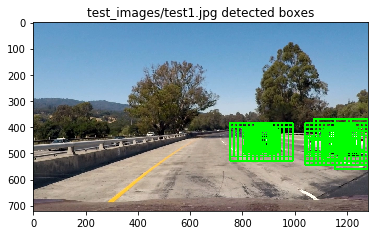

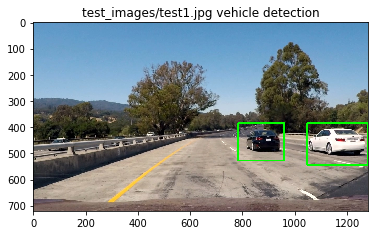

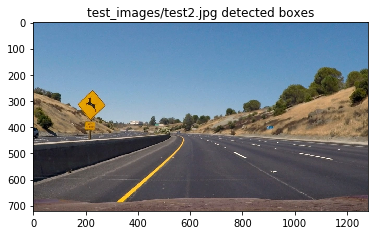

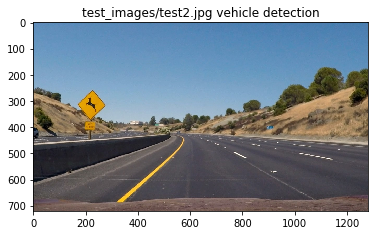

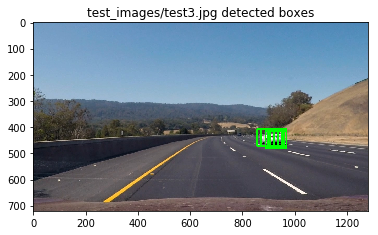

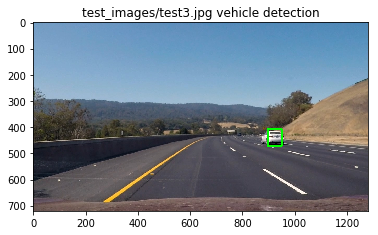

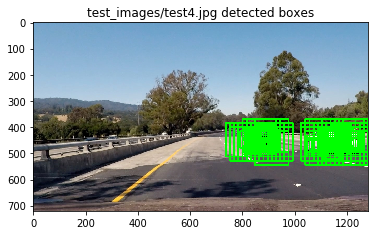

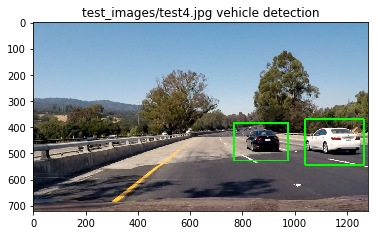

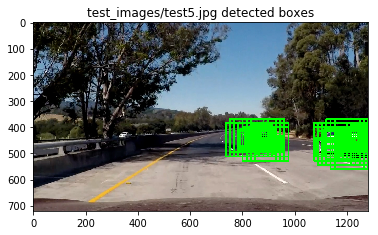

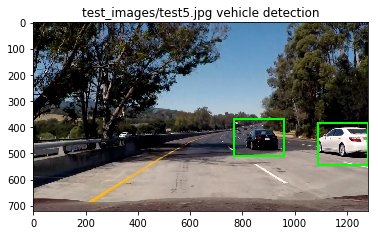

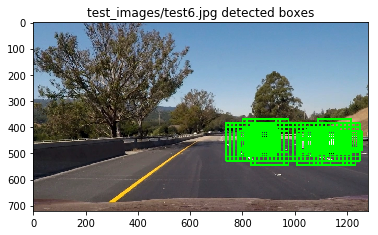

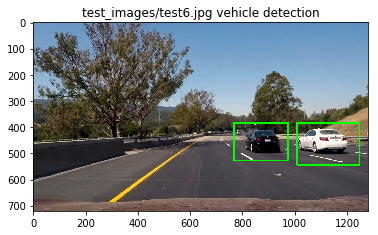

In [452]:
detection_model = vehicleDetectionModel(input_shape=(None, None, 3))
detection_model.load_weights('model.h5')

test_images = glob.glob('test_images/*.jpg')
#test_images = glob.glob('test_images/test3.jpg')
#test_images = glob.glob('tmp/image1.jpg')
for imagefile in test_images:
    image = cv2.imread(imagefile)
    draw_image = vehicleDetection(image, 'BGR', model=detection_model, visualize=True)

In [453]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [454]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = vehicleDetection(image, 'RGB', model=detection_model)
    process_image.imgcount += 1
    if process_image.imgcount <= process_image.maxcount:
        cv2.imwrite('tmp/image'+str(process_image.imgcount)+'.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        cv2.imwrite('tmp/result'+str(process_image.imgcount)+'.jpg', cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    return result
process_image.imgcount = 0
process_image.maxcount = 0

In [455]:
video_output = 'project_video_w_vehicles.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_w_vehicles.mp4
[MoviePy] Writing video project_video_w_vehicles.mp4


100%|█████████▉| 1260/1261 [01:37<00:00, 12.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_w_vehicles.mp4 

CPU times: user 1min 34s, sys: 8.77 s, total: 1min 43s
Wall time: 1min 38s


In [456]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))